# **Natural Language Processing: Named-Entity Recognition**

### **Phân tích bài toán theo TEPFA:**

Task:  đánh dấu tên của thực thể trong văn bản.

Experience:  bộ dữ liệu đã được đánh nhãn.

Performance:  accuracy, f1-score

Function: Sử dụng pretrain của BERT

Algorithm: Adam


In [1]:
import os
os.chdir('/content/drive/My Drive/BERT/NER')

In [2]:
!nvidia-smi

Fri Jan 22 11:52:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 6.3MB/s 
     |████████████████████████████████| 890kB 33.2MB/s 
     |████████████████████████████████| 2.9MB 60.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ffcf3e3ef773950cde0645fe23797f43a72cfbcbca88ab6230920d3061dc566c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import pandas as pd
import numpy as np
import torch

data = pd.read_csv('ner_dataset.csv', encoding='latin1').fillna(method='ffill')
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [5]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                   s["POS"].values.tolist(),
                                                   s["Tag"].values.tolist())]
grouped = data.groupby('Sentence #').apply(agg_func)
get_sentences = [s for s in grouped]

In [6]:
sentences = [[word[0] for word in sentence] for sentence in get_sentences]
print(sentences[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']


In [7]:
tags = [[s[2] for s in sentence] for sentence in get_sentences]
print(tags[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


## **Các nhãn trong dataset**

+ geo = Geographical Entity
+ org = Organization
+ per = Person
+ gpe = Geopolitical Entity
+ tim = Time indicator
+ art = Artifact
+ eve = Event
+ nat = Natural Phenomenon

In [8]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t:i for i, t in enumerate(tag_values)}
print(tag_values)

['I-org', 'I-gpe', 'O', 'B-tim', 'I-nat', 'I-art', 'B-art', 'I-per', 'B-nat', 'I-eve', 'B-gpe', 'B-per', 'B-org', 'I-tim', 'B-geo', 'I-geo', 'B-eve', 'PAD']


In [9]:
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import SequentialSampler, RandomSampler, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 78
BATCH_SIZE = 64
device = torch.device("cuda")

In [10]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-cased',
    do_lower_case=False
)

## Tiến hành thực hiện encoding các câu và nhãn trong dataset
+ MAX_LEN = 78
+ BATCH_SIZE = 64

In [11]:
def tokenize_and_preserve_tags(sentence, text_tags):
    tokenized_sentence = []
    tags = []

    for word, tag in zip(sentence, text_tags):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        tags.extend([tag]*n_subwords)
    
    return tokenized_sentence, tags

In [12]:
tokenized_texts_and_tags = [
    tokenize_and_preserve_tags(sent, text_tags)
    for sent, text_tags in zip(sentences, tags)
]

In [13]:
tokenized_texts = [token_tag_pair[0] for token_tag_pair in tokenized_texts_and_tags]
tags = [token_tag_pair[1] for token_tag_pair in tokenized_texts_and_tags]

In [14]:
print(tokenized_texts[0])
print(tags[0])

['Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


Tiến hành padding các câu trong datatrain, nếu câu ngắn hơn MAX_LEN thì thêm 0 vào phần cuối của câu, nếu câu dài hơn thì sẽ cắt bớt.

In [15]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype='long', padding='post', truncating='post', value=0.0)
print(input_ids[0])

[26159  1104  8568  4487  5067  1138  9639  1194  1498  1106  5641  1103
  1594  1107  5008  1105  4555  1103 10602  1104  1418  2830  1121  1115
  1583   119     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [16]:
labels = pad_sequences([[tag2idx.get(t) for t in text_tags] for text_tags in tags],
                       maxlen=MAX_LEN, dtype='long', padding='post', truncating='post', value=tag2idx["PAD"])
print(labels[0])

[ 2  2  2  2  2  2  2  2 14  2  2  2  2  2 14  2  2  2  2  2 10  2  2  2
  2  2 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]


In [17]:
attention_masks = [[int(i != 0) for i in ii] for ii in input_ids]
print(attention_masks[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
tr_inputs, val_inputs, tr_labels, val_labels = train_test_split(input_ids, labels, random_state=1, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=1, test_size=0.1)

Sử dụng hàm trong thư viện pytorch để tải dataset vào model trong quá trình training.

In [19]:
tr_inputs = torch.tensor(tr_inputs)
tr_masks = torch.tensor(tr_masks)
tr_labels = torch.tensor(tr_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(val_masks)
val_labels = torch.tensor(val_labels)

train_data = TensorDataset(tr_inputs, tr_masks, tr_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

**Function**: Sử dụng pretrain của BERT + đầu multiclass classification cho bài toán phân loại này.

In [20]:
model = BertForTokenClassification.from_pretrained(
    'bert-base-cased',
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

**Performance**: sử dụng accuracy, f1-score để đánh giá chất lượng của model

**Algorithm**: Adam



In [21]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate':0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate':0.00}
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

Sử dụng scheduler để giảm learning rate theo thời gian

In [22]:
EPOCHS = 10

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [23]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import notebook

train_loss_values, eval_loss_values = [], []

for epoch in range(EPOCHS):
    print("=========== Epoch {}/{} ===========".format(epoch+1, EPOCHS))
    print("=========== Training ==============")

    model.train()
    train_loss = 0

    for batch in notebook.tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        train_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = train_loss / len(train_dataloader)
    print("Average training loss: {:5f}".format(avg_train_loss))
    train_loss_values.append(avg_train_loss)

    print("=========== Evaluation ===========")
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in notebook.tqdm(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        val_loss += outputs[0].item()
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    
    avg_eval_loss = val_loss / len(val_dataloader)
    print("Average evaluation loss: {:5f}".format(avg_eval_loss))
    eval_loss_values.append(avg_eval_loss)

    pred_tags = [tag_values[d_i] for d, l in zip(predictions, true_labels)
                                 for d_i, l_i in zip(d, l) if tag_values[l_i] != "PAD"]
    val_tags = [tag_values[l_i] for l in true_labels
                                for l_i in l if tag_values[l_i] != "PAD"]
    print("Evaluation accuracy: {:5f}".format(accuracy_score(pred_tags, val_tags)))
    print("Evaluation F1-score: {:5f}".format(f1_score(pred_tags, val_tags, average='weighted')))
    print("\n\n")
    torch.save(model.state_dict(), "/content/drive/MyDrive/BERT/NER/saved_model/epoch{}.pth".format(epoch))

=========== Epoch 1/10 ===========
=========== Training ==============



Average training loss: 0.217779
=========== Evaluation ===========



Average evaluation loss: 0.137589
Evaluation accuracy: 0.958076
Evaluation F1-score: 0.959140



=========== Epoch 2/10 ===========
=========== Training ==============



Average training loss: 0.118532
=========== Evaluation ===========



Average evaluation loss: 0.124862
Evaluation accuracy: 0.960787
Evaluation F1-score: 0.961315



=========== Epoch 3/10 ===========
=========== Training ==============



Average training loss: 0.090282
=========== Evaluation ===========



Average evaluation loss: 0.132259
Evaluation accuracy: 0.962179
Evaluation F1-score: 0.962696



=========== Epoch 4/10 ===========
=========== Training ==============



Average training loss: 0.070078
=========== Evaluation ===========



Average evaluation loss: 0.139945
Evaluation accuracy: 0.962459
Evaluation F1-score: 0.962768



=========== Epoch 5/10 ===========
=========== Training ==============



Average training loss: 0.055029
=========== Evaluation ===========



Average evaluation loss: 0.146796
Evaluation accuracy: 0.963382
Evaluation F1-score: 0.963853



=========== Epoch 6/10 ===========
=========== Training ==============



Average training loss: 0.043833
=========== Evaluation ===========



Average evaluation loss: 0.160736
Evaluation accuracy: 0.963597
Evaluation F1-score: 0.964024



=========== Epoch 7/10 ===========
=========== Training ==============



Average training loss: 0.035279
=========== Evaluation ===========



Average evaluation loss: 0.172146
Evaluation accuracy: 0.963053
Evaluation F1-score: 0.963374



=========== Epoch 8/10 ===========
=========== Training ==============



Average training loss: 0.029584
=========== Evaluation ===========



Average evaluation loss: 0.184155
Evaluation accuracy: 0.962838
Evaluation F1-score: 0.963135



=========== Epoch 9/10 ===========
=========== Training ==============



Average training loss: 0.025004
=========== Evaluation ===========



Average evaluation loss: 0.187688
Evaluation accuracy: 0.962904
Evaluation F1-score: 0.963141



=========== Epoch 10/10 ===========
=========== Training ==============



Average training loss: 0.022068
=========== Evaluation ===========



Average evaluation loss: 0.191858
Evaluation accuracy: 0.963152
Evaluation F1-score: 0.963453





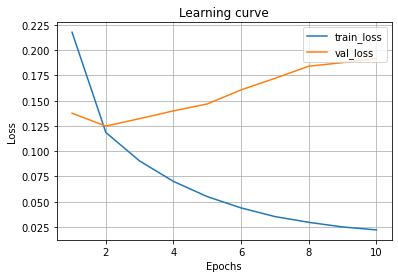

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, EPOCHS+1), train_loss_values, label='train_loss')
plt.plot(range(1, EPOCHS+1), eval_loss_values, label='val_loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend(loc='upper right')
plt.show()

Sử dụng model để phân tích named-entity của một câu.

In [25]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

In [26]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).to('cuda')

In [27]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].cpu().numpy(), axis=2)[0]

In [28]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_tags = [], []

for token, label in zip(tokens, label_indices):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_tokens.append(token)
        new_tags.append(tag_values[label])

In [29]:
for token, tag in zip(new_tokens, new_tags):
    print("{}\t{}".format(token, tag))

[CLS]	O
Mr	B-per
.	B-per
Trump	I-per
’	O
s	O
tweets	O
began	O
just	O
moments	O
after	O
a	O
Fox	B-org
News	I-org
report	O
by	O
Mike	B-per
Tobin	I-per
,	O
a	O
reporter	O
for	O
the	O
network	O
,	O
about	O
protests	O
in	O
Minnesota	B-geo
and	O
elsewhere	O
.	O
[SEP]	O
